In [1]:
import sys
from astropy.io import fits
import glob
import numpy as np
import time
import resource
import subprocess
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
def plotImage(image_data):
    plt.figure()
    plt.imshow(image_data)
    plt.colorbar()
    plt.title('Imagen FITS')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.savefig('Image-disk.png')
    plt.show()

def plotVelocity(X, Y, vx, vy, titlex, titley):
    
    # Visualización de las componentes de velocidad
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(vx, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', aspect='auto', cmap='magma')
    #plt.pcolormesh(X, Y, vx)
    plt.colorbar(label='Velocidad')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(titlex)
    plt.axis('equal')
    
    plt.subplot(1, 2, 2)
    plt.imshow(vy, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', aspect='auto', cmap='magma')
    #plt.pcolormesh(X, Y, vy)
    plt.colorbar(label='Velocidad')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(titley)
    plt.axis('equal')
    
    plt.tight_layout()
    plt.savefig('Velocity-disk.png')
    plt.show()

In [3]:
def plotVelocityField(X, Y, Vx, Vy, npix):
    
    speed = np.sqrt(Vx**2 + Vy**2)
    lw = 3.5*speed / speed.max()

    plt.figure(figsize=(6, 6))
    strm = plt.streamplot(X, Y, Vx, Vy, color=speed, linewidth=lw, cmap='magma')
    plt.colorbar(strm.lines)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Velocity Field')
    plt.show()

In [4]:
pnt = True

In [5]:
# Obtener campos de velocidad e interpolar datos para cambiar dimension de los arreglos ---> Actualmente se trabaja con dust1v
def get_velocity_polar(file_path_field, out, npix):

    # Leer los datos del archivo 'domain_y.dat', excluyendo los primeros 3 y los últimos 4 valores
    # En su interior contiene los radios (r) --> coordenadas radiales 
    r = np.loadtxt(file_path_field + 'domain_y.dat')[3:-4]
    
    # Leer los datos del archivo 'domain_x.dat', excluyendo el último valor
    # En su interior contiene los ángulos (φ) --> coordenadas angulares (azimutales)
    phi = np.loadtxt(file_path_field + 'domain_x.dat')[:-1]
    
    if pnt: 
        print("R shape: ", r.shape)
        print("Phi shape: ", phi.shape)
    
    # Determinar la cantidad de elementos en r y phi
    nr = len(r)
    nphi = len(phi)
    
    # Crear una malla de coordenadas polares (Phi, R) usando phi y r
    Phi, R = np.meshgrid(phi, r)
    
    # Convertir las coordenadas polares (Phi, R) a coordenadas cartesianas (X, Y)
    X = R * np.cos(Phi)
    Y = R * np.sin(Phi)
    
    if pnt:
        print("Coordenadas cartesianas - shape: ", X.shape, Y.shape)
        print("Original X range:", X.min(), X.max())
        print("Original Y range:", Y.min(), Y.max())
    
    # Leer datos de velocidades polares
    # Velocidades en las direcciones radial en coordenadas polares
    Vr = np.fromfile(file_path_field + 'dust1vy{:d}.dat'.format(out), dtype=np.float64).reshape(nr, nphi)
    
    # Velocidades en las direcciones azimutal en coordenadas polares
    Vphi = np.fromfile(file_path_field + 'dust1vx{:d}.dat'.format(out), dtype=np.float64).reshape(nr, nphi)
    
    if pnt: 
        print("Vr shape: ", Vr.shape)
        print("Vphi shape: ", Vphi.shape)
        print("Vr Max: ", Vr.max(), " Vr Min: ", Vr.min())
        print("Vphi Max: ", Vphi.max(), " Vphi Min: ", Vphi.min())
        plotVelocity(X, Y, Vr, Vphi, 'Componente de Velocidad R', 'Componente de Velocidad Phi') 

    # Crear una malla de coordenadas polares para la nueva grilla
    new_r = np.linspace(R.min(), R.max(), npix)
    new_phi = np.linspace(Phi.min(), Phi.max(), npix)
    new_Phi, new_R = np.meshgrid(new_phi, new_r)

    if pnt:
        print("Grilla : ", new_Phi.shape, new_R.shape)
        print("Nuevas coordenadas polares - shape: ", new_Phi.shape, new_R.shape)
        print("New Phi range:", new_Phi.min(), new_Phi.max())
        print("New R range:", new_R.min(), new_R.max())

    # Convertir las nuevas coordenadas polares a coordenadas cartesianas para la interpolación
    new_X = new_R * np.cos(new_Phi)
    new_Y = new_R * np.sin(new_Phi)
    
    if pnt:
        print("Grilla : ", new_X.shape, new_Y.shape)
        print("Nuevas coordenadas cartesianas - shape: ", new_X.shape, new_Y.shape)
        print("New X range:", new_X.min(), new_X.max())
        print("New Y range:", new_Y.min(), new_Y.max())
        
    # Interpolar los datos de velocidad a la nueva grilla - nearest es más rapido y no tienen problemas con valores atipicos
    new_Vr = griddata((X.ravel(), Y.ravel()), Vr.ravel(), (new_X, new_Y), method='nearest')
    new_Vphi = griddata((X.ravel(), Y.ravel()), Vphi.ravel(), (new_X, new_Y), method='nearest')
    
    
    if pnt:
        print("Nuevas dimensiones Vr - Vphi - shape: ", new_Vr.shape, new_Vphi.shape)
        print("new_Vr Max: ", new_Vr.max(), " new_Vr Min: ", new_Vr.min())
        print("new_Vphi Max: ", new_Vphi.max(), " new_Vphi Min: ", new_Vphi.min())
        print("Number of NaNs in new_vx:", np.isnan(new_Vr).sum())
        print("Number of NaNs in new_vy:", np.isnan(new_Vphi).sum())

    if pnt:
        plotVelocity(new_X, new_Y, new_Vr, new_Vphi, 'Componente de Velocidad new_R', 'Componente de Velocidad new_Phi')

    return new_Vr, new_Vphi, new_X, new_Y

In [20]:
# Obtener campos de velocidad e interpolar datos para cambiar dimension de los arreglos ---> Actualmente se trabaja con dust1v
def get_velocity(file_path_field, out, npix):

    # Leer los datos del archivo 'domain_y.dat', excluyendo los primeros 3 y los últimos 4 valores
    # En su interior contiene los radios (r) --> coordenadas radiales 
    r = np.loadtxt(file_path_field + 'domain_y.dat')[3:-4]
    
    # Leer los datos del archivo 'domain_x.dat', excluyendo el último valor
    # En su interior contiene los ángulos (φ) --> coordenadas angulares (azimutales)
    phi = np.loadtxt(file_path_field + 'domain_x.dat')[:-1]
    
    if pnt: 
        print("R shape: ", r.shape)
        print("Phi shape: ", phi.shape)
    
    # Determinar la cantidad de elementos en r y phi
    nr = len(r)
    nphi = len(phi)
    
    # Leer datos de velocidades polares
    # Velocidades en las direcciones radial en coordenadas polares
    Vr = np.fromfile(file_path_field + 'dust1vy{:d}.dat'.format(out), dtype=np.float64).reshape(nr, nphi)
    
    # Velocidades en las direcciones azimutal en coordenadas polares
    Vphi = np.fromfile(file_path_field + 'dust1vx{:d}.dat'.format(out), dtype=np.float64).reshape(nr, nphi)
        
    if pnt: # Para verificar datos polares (grafica de datos polares en grilla cartesiana)
        
        # Crear una malla de coordenadas polares (Phi, R) usando phi y r
        Phi, R = np.meshgrid(phi, r)
        
        # Convertir las coordenadas polares (Phi, R) a coordenadas cartesianas (X, Y)
        X = R * np.cos(Phi)
        Y = R * np.sin(Phi)

        print("Coordenadas cartesianas - shape: ", X.shape, Y.shape)
        print("Original X range:", X.min(), X.max())
        print("Original Y range:", Y.min(), Y.max())
        
        print("Vr shape: ", Vr.shape)
        print("Vphi shape: ", Vphi.shape)
        print("Vr Max: ", Vr.max(), " Vr Min: ", Vr.min())
        print("Vphi Max: ", Vphi.max(), " Vphi Min: ", Vphi.min())
        plotVelocity(X, Y, Vr, Vphi, 'Componente de Velocidad R', 'Componente de Velocidad Phi') 

    # Para convertirlas a coordenadas cartesianas:
        
    # Crear matrices para los ángulos φ en el rango [0, 2π)
    phi_matrix = np.tile(phi, (nr, 1))
    
    # Convertir de coordenadas polares a cartesianas
    Vx = Vr * np.cos(phi_matrix) - Vphi * np.sin(phi_matrix)
    Vy = Vr * np.sin(phi_matrix) + Vphi * np.cos(phi_matrix)
    
    # Crear una malla de coordenadas polares (Phi, R) usando phi y r
    Phi, R = np.meshgrid(phi, r)
    
    # Convertir las coordenadas polares (Phi, R) a coordenadas cartesianas (X, Y)
    X = R * np.cos(Phi)
    Y = R * np.sin(Phi)
    
    # Crear una malla cartesiana con dimensiones fijas de tamaño de pixel
    new_x = np.linspace(X.min(), X.max(), npix)
    new_y = np.linspace(Y.min(), Y.max(), npix)
    new_X, new_Y = np.meshgrid(new_x, new_y)
    
    # Interpolar los datos de velocidad a la nueva grilla - nearest es más rapido y no tienen problemas con valores atipicos
    Vx_cartesian = griddata((X.ravel(), Y.ravel()), Vx.ravel(), (new_X, new_Y), method='nearest')
    Vy_cartesian = griddata((X.ravel(), Y.ravel()), Vy.ravel(), (new_X, new_Y), method='nearest')

    if pnt:
        print("Dimensiones Vx, Vy - shape: ", Vx.shape, Vy.shape)
        print("Vx Max: ", Vx.max(), " Vx Min: ", Vx.min())
        print("Vy Max: ", Vy.max(), " Vy Min: ", Vy.min())
        plotVelocity(X, Y, Vx, Vy, 'Componente de Velocidad X cartesian', \
                     'Componente de Velocidad Y cartesian')
        
        print("Nuevas dimensiones X, Y - shape: ", new_X.shape, new_Y.shape)
        print("Nuevas dimensiones Vx, Vy - shape: ", Vx_cartesian.shape, Vy_cartesian.shape)
        print("Vx cartesian npix Max: ", Vx_cartesian.max(), " Vx cartesian npix Min: ", Vx_cartesian.min())
        print("Vy cartesian npix Max: ", Vy_cartesian.max(), " Vy cartesian npix Min: ", Vy_cartesian.min())
        print("Number of NaNs in Vy_cartesian:", np.isnan(Vx_cartesian).sum())
        print("Number of NaNs in Vy_cartesian:", np.isnan(Vy_cartesian).sum())
        
        plotVelocity(new_X, new_Y, Vx_cartesian, Vy_cartesian, 'Componente de Velocidad X cartesian npix', \
                     'Componente de Velocidad Y cartesian npix')
        plotVelocityField(new_X, new_Y, Vx_cartesian, Vy_cartesian, npix)

    return Vx_cartesian, Vy_cartesian, new_X, new_Y

In [7]:
#__________________________________GUARDAR DATOS___________________________________

##GENERAL SETTING####
#simulation = 290
simulation = 1
offset = 0
time_step = 20
#time_step = 1
npix = 300

# Archivos con errores en las simulaciones
err_sim = [9, 18, 26, 29, 36, 71, 83, 91, 92, 93, 134, 136, 143, 151, 153, 170, 182, 196, 197, 211, 243, 253, 265, 270, 276, 282, 287]

##VELOCITY SETTING###
images_data_norm_tot = []
output_np_file_name_img = "./numpyFile_simulation_images_real"

##VELOCITY SETTING###
v_time = 19 # Indice del time step para obtener el campo de velocidades (19 last)
vfield_data_norm_x_tot = []
vfield_data_norm_y_tot = []
vfield_data_coordinates_tot = []
output_np_file_name_vel_x = "./numpyFile_simulation_velocity_x_real"
output_np_file_name_vel_y = "./numpyFile_simulation_velocity_y_real"
output_np_file_name_coordinates_vel = "./numpyFile_simulation_velocity_coordinates"

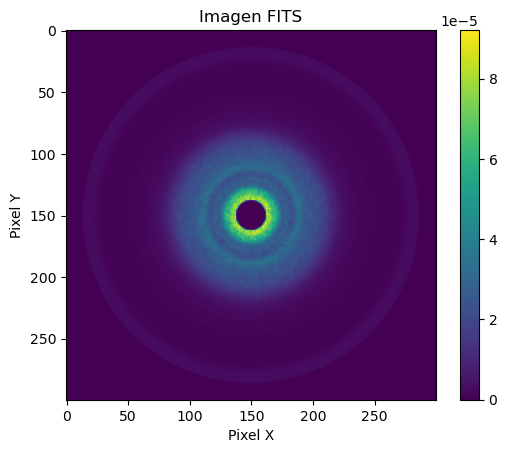

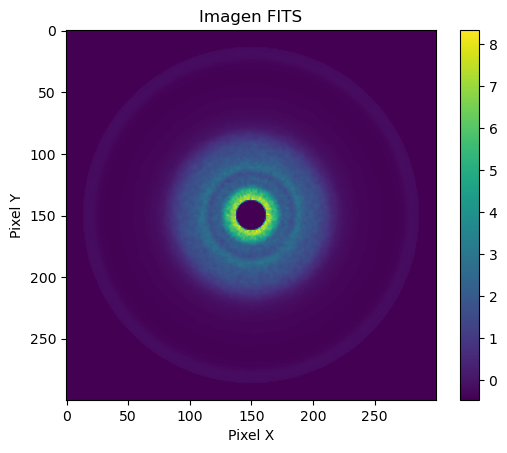

std: 1.0459777899099263e-05 and mean: 4.932012304612207e-06 of data image
std: 1.0 and mean: -2.1701389130157622e-08 of normalizate data image



R shape:  (512,)
Phi shape:  (1024,)
Coordenadas cartesianas - shape:  (512, 1024) (512, 1024)
Original X range: -4.44208984375 4.44208984375
Original Y range: -4.44208984375 4.44208984375
Vr shape:  (512, 1024)
Vphi shape:  (512, 1024)
Vr Max:  0.012473092534604293  Vr Min:  -0.015392879827544467
Vphi Max:  1.573882088625181  Vphi Min:  0.4741332144403112


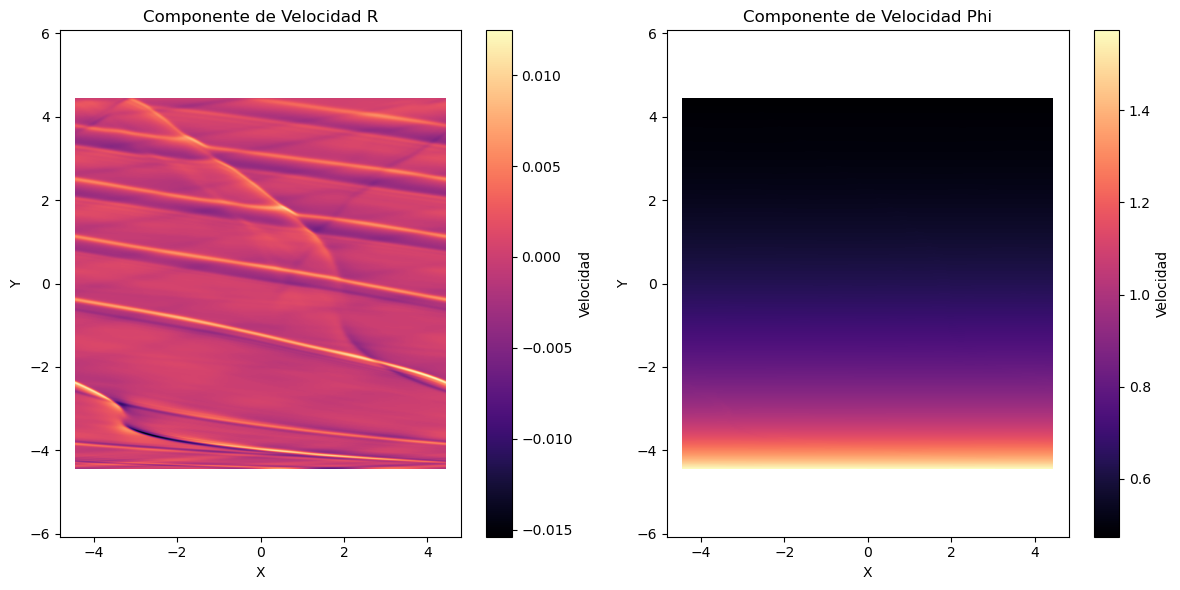

Dimensiones Vx, Vy - shape:  (512, 1024) (512, 1024)
Vx Max:  1.5733849131836635  Vx Min:  -1.5738369791546787
Vy Max:  1.5736544730940147  Vy Min:  -1.573168185939103


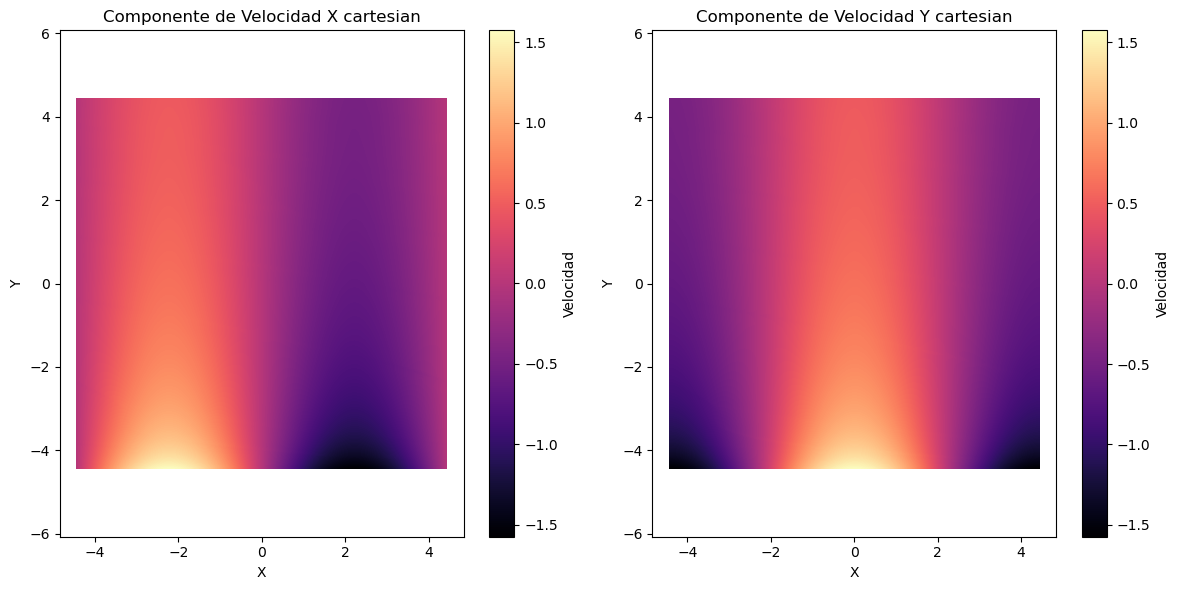

Nuevas dimensiones X, Y - shape:  (300, 300) (300, 300)
Nuevas dimensiones Vx, Vy - shape:  (300, 300) (300, 300)
Vx cartesian npix Max:  1.5723225374302496  Vx cartesian npix Min:  -1.572873176215432
Vy cartesian npix Max:  1.5726757363806105  Vy cartesian npix Min:  -1.5721550694777562
Number of NaNs in Vy_cartesian: 0
Number of NaNs in Vy_cartesian: 0


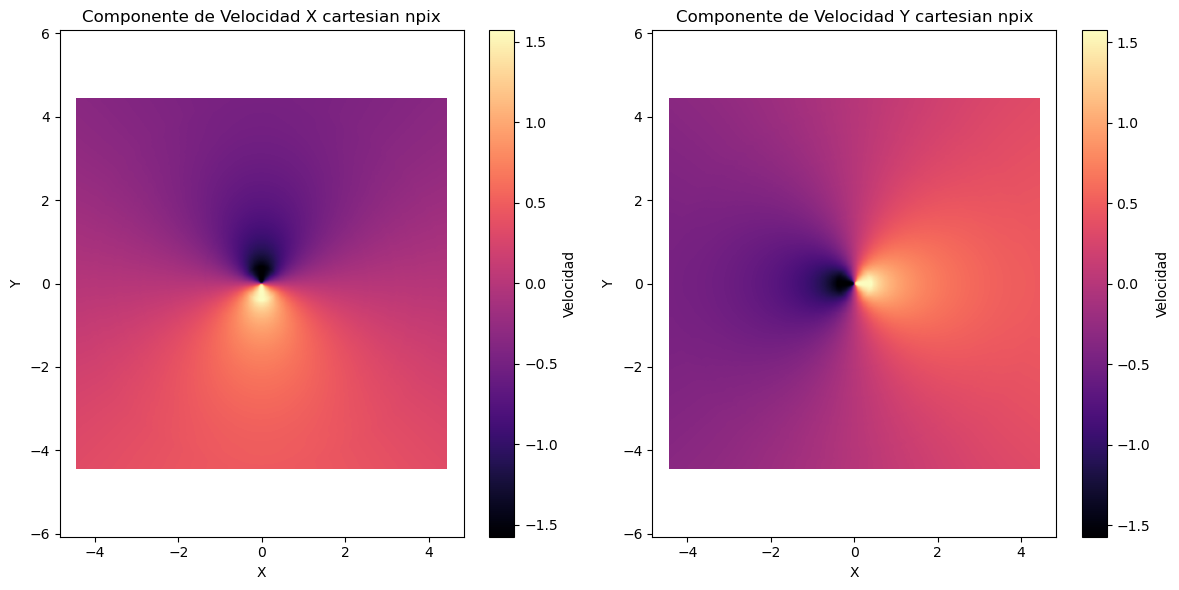

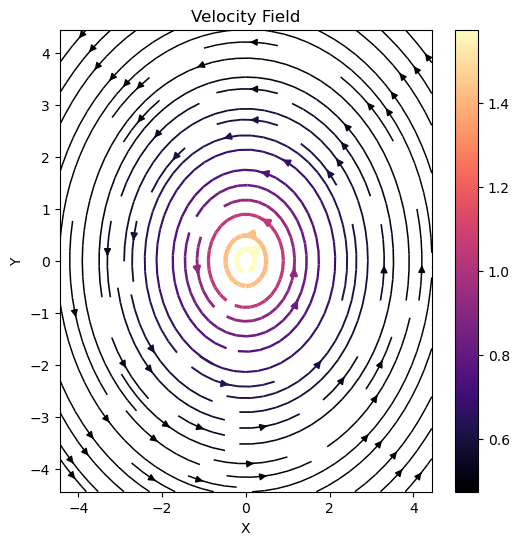

std: 0.4344871939741132 and mean: 8.920578972255397e-06 of data vx
std: 0.4345249197604551 and mean: -7.133482238148585e-05 of data vy
std: 1.0 and mean: 0.0 of normalizate data vx
std: 1.0 and mean: 0.0 of normalizate data vy

 ===== SAVING numpy files to local disk
(13, 19, 300, 300)
(13, 300, 300)
(13, 300, 300)
(13, 2, 300, 300)
CPU times: user 5.33 s, sys: 49.7 ms, total: 5.38 s
Wall time: 5.39 s


In [21]:
%%time
for sim in range(simulation):

    if (sim+offset) in err_sim:
        continue

    images_data_norm_by_sim = []

    for t in range(1, time_step):
    
        ###TIME####
        # Ruta donde esten guardadas los imagenes
        file_path_time = f'/disk2/alma/pipeline/RT/All_sim_pix{npix:01d}/sim_{(sim+offset):01d}/output_{t:01d}/image_out_wl1300.fits'

        hdulist = fits.open(file_path_time, mode='readonly', do_not_scale_image_data=True)
        image_data = hdulist[0].data
        hdulist.close()
        image_data = np.squeeze(image_data) #arreglar dimension

        # Normalizar datos utilizando Z-Score:
        image_data_norm = np.divide((image_data - np.mean(image_data)), np.std(image_data), dtype=np.float32)
        
        # Normalizar datos utilizando Norm min-max
        #aux_norm = image_data - image_data.min()
        #image_data_norm = np.divide(aux_norm, aux_norm.max(), dtype=np.float32)

        images_data_norm_by_sim.append(image_data_norm)

        if(t == (time_step-1) and pnt): 
            plotImage(image_data)
            plotImage(image_data_norm)
            print(f'std: {np.std(image_data)} and mean: {np.mean(image_data)} of data image')
            print(f'std: {np.std(image_data_norm)} and mean: {np.mean(image_data_norm)} of normalizate data image')
            print("\n\n")

    images_data_norm_tot.append(images_data_norm_by_sim)
    ###VELOCITY###
    # Ruta donde estan guardadas las velocidades
    file_path_field = f'/disk2/alma/pipeline/hydro/outputs/Alma_outputs/sim_{(sim+offset):01d}/'

    # Obtener velocidades del polvo (dust1) del ultimo paso de tiempo (cambiar función a gusto)
    vfield_data_x, vfield_data_y, coordinates_x, coordinates_y = get_velocity(file_path_field, v_time, npix)

    vfield_data_coordinates_par = []

    # Normalizar datos utilizando Z-Score:
    vfield_data_norm_x = np.divide((vfield_data_x - np.mean(vfield_data_x)), np.std(vfield_data_x), dtype=np.float32)
    
    # Normalizar datos utilizando Norm min-max
    #aux_norm = vfield_data_x - vfield_data_x.min()
    #vfield_data_norm_x = np.divide(aux_norm, aux_norm.max(), dtype=np.float32)
    
    vfield_data_norm_x_tot.append(vfield_data_norm_x)
    

    vfield_data_norm_y = np.divide((vfield_data_y - np.mean(vfield_data_y)), np.std(vfield_data_y), dtype=np.float32)
    
    #aux_norm = vfield_data_y - vfield_data_y.min()
    #vfield_data_norm_y = np.divide(aux_norm, aux_norm.max(), dtype=np.float32)
    
    vfield_data_norm_y_tot.append(vfield_data_norm_y)

    if pnt:
        print(f'std: {np.std(vfield_data_x)} and mean: {np.mean(vfield_data_x)} of data vx')
        print(f'std: {np.std(vfield_data_y)} and mean: {np.mean(vfield_data_y)} of data vy')
        print(f'std: {np.std(vfield_data_norm_x)} and mean: {np.mean(vfield_data_norm_x)} of normalizate data vx')
        print(f'std: {np.std(vfield_data_norm_y)} and mean: {np.mean(vfield_data_norm_y)} of normalizate data vy')

    vfield_data_coordinates_par.append(coordinates_x)
    vfield_data_coordinates_par.append(coordinates_y)
    vfield_data_coordinates_tot.append(vfield_data_coordinates_par)

images_data_norm_tot_np = np.asarray(images_data_norm_tot)
vfield_data_norm_x_tot_np = np.asarray(vfield_data_norm_x_tot)
vfield_data_norm_y_tot_np = np.asarray(vfield_data_norm_y_tot)
vfield_data_coordinates_tot_np = np.asarray(vfield_data_coordinates_tot)

print("\n ===== SAVING numpy files to local disk")
print(images_data_norm_tot_np.shape)
print(vfield_data_norm_x_tot_np.shape)
print(vfield_data_norm_y_tot_np.shape)
print(vfield_data_coordinates_tot_np.shape)

#np.save(output_np_file_name_img, images_data_norm_tot_np)
#np.save(output_np_file_name_vel_x, vfield_data_norm_x_tot_np)
#np.save(output_np_file_name_vel_y, vfield_data_norm_y_tot_np)
#np.save(output_np_file_name_coordinates_vel, vfield_data_coordinates_tot_np)

In [24]:
from sklearn.metrics import r2_score